# Brain Stroke Detection

Done by:
 - 21BCE011
 - 21BCE012
 - 21BCE020
---

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn.metrics import auc,roc_auc_score,roc_curve,precision_score,recall_score,f1_score

In [13]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.DataFrame(pd.read_csv("/content/drive/MyDrive/healthcare-dataset-stroke-data.csv"))
df.info()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [14]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Stroke = 1 indicates stroke risk being detected.

Stroke = 0 indicates no stroke risk detected.

---

## Data Preprocessing

 - Check for missing values and fill accordingly
 - Smooth the outliers if necessary
 - Reduction and Transformation are not needed due to small size of dataset

In [15]:
# Remove irrelevant columns for further processing
df = df.drop(columns=['id'])

In [16]:
# Check missing values
print(df.isna().any())

gender               False
age                  False
hypertension         False
heart_disease        False
ever_married         False
work_type            False
Residence_type       False
avg_glucose_level    False
bmi                   True
smoking_status       False
stroke               False
dtype: bool


In [18]:
# Check outliers
q1 = df['bmi'].quantile(0.25)
q3 = df['bmi'].quantile(0.75)
iqr = q3 - q1
outliers = (df['bmi'] < (q1 - 1.5 * iqr)) | (df['bmi'] > (q3 + 1.5 * iqr))
outliers.value_counts()

bmi
False    5000
True      110
Name: count, dtype: int64

In [22]:
# Fill missing values with mean
df['bmi'] = df['bmi'].fillna(df['bmi'].mean())

In [23]:
# Label Encoding - Convert categorical values to integers for computation
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
label_encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = label_encoder.fit_transform(df[col])

In [24]:
# Check whether dataset is balanced or not
print("Number of cases with no stroke detected: ", sum(df['stroke'] == 0))
print("Number of cases with stroke detected: ", sum(df['stroke'] == 1))

Number of cases with no stroke detected:  4861
Number of cases with stroke detected:  249


---

## Imbalanced Dataset
The dataset being used in imbalanced due to uneven distribution of the class label 'stroke'.

In [25]:
# Split dataset
X = df.drop(['stroke'], axis=1)
y = df['stroke']
X_train, X_test , y_train , y_test = train_test_split(X, y, test_size = 0.2)

In [26]:
# Balance dataset using SMOTE (Synthetic Minority Oversampling Technique) approach
print("Before (label '1'): {}".format(sum(y_train == 1)))
print("Before (label '0'): {} \n".format(sum(y_train == 0)))
smo = SMOTE()
X_res, y_res = smo.fit_resample(X_train, y_train.ravel())
print("After (label '1'):", sum(y_res == 1))
print("After (label '0'):", sum(y_res == 0))

Before (label '1'): 206
Before (label '0'): 3882 

After (label '1'): 3882
After (label '0'): 3882


In [27]:
# Split the data based on balanced dataset
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_res, y_res, random_state = 42)

---

## Data Normalization

In [28]:
# Data Normalization

# Z-Score Normalization
scaler1 = StandardScaler()
X_train_scaled_1 = scaler1.fit_transform(X_train_new)
X_test_scaled_1 = scaler1.transform(X_test_new)

---

## Data Mining

  - Bagging and Boosting Classifiers

In [29]:
# Random Forest
RF = RandomForestClassifier()
RF.fit(X_train_scaled_1, y_train_new)
y_pred_RF = RF.predict(X_test_scaled_1)

# BaggingClassifier
BC = BaggingClassifier()
BC.fit(X_train_scaled_1, y_train_new)
y_pred_BC = BC.predict(X_test_scaled_1)

# Adaboost
ADA = AdaBoostClassifier()
ADA.fit(X_train_scaled_1, y_train_new)
y_pred_ADA = ADA.predict(X_test_scaled_1)

# XGBoost
XGB = xgb.XGBClassifier()
XGB.fit(X_train, y_train)
y_pred_XGB = XGB.predict(X_test_scaled_1)

# K-Nearest Neighbours
KNN = KNeighborsClassifier()
KNN.fit(X_train_scaled_1, y_train_new)
y_pred_KNN = KNN.predict(X_test_scaled_1)

---

## Evaluation Metrics

In [34]:
def sen_spe(y_true,y_pred):
    CM = confusion_matrix(y_true,y_pred)
    TP = CM[1][1]
    TN = CM[0][0]
    FP = CM[0][1]
    FN = CM[1][0]
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    return sensitivity,specificity

In [37]:
def evaluate_model(model, X_test, y_test):
  y_pred = model.predict(X_test)
  y_prob = model.predict_proba(X_test)
  print("Classification Report:\n{}".format(classification_report(y_test, y_pred)))
  accuracy = accuracy_score(y_test, y_pred)
  print("Accuracy Score: {:.2f}".format(accuracy))
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  sensitivity, specificity = sen_spe(y_test, y_pred)
  auc = roc_auc_score(y_test, y_prob[:,1])
  fpr, tpr, _ = roc_curve(y_test,  y_prob[:,1])
  print("Precision Score: {:.2f}".format(precision))
  print("Recall Score: {:.2f}".format(recall))
  print("F1 Score: {:.2f}".format(f1))
  print("Sensitivity: {:.2f}".format(sensitivity))
  print("Specificity: {:.2f}".format(specificity))
  print("AUC score: {:.2f}".format(auc))
  fig, ax = plt.subplots()
  ax.plot(fpr, tpr, color='purple', label='ROC curve (area = %0.2f)' % auc)
  ax.plot([0, 2], [0, 2], color='orange', linestyle='--')
  ax.set_xlim([-0.1, 1.0])
  ax.set_ylim([0.0, 1.1])
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('Receiver Operating Characteristic')
  ax.legend(loc = "lower right")
  plt.show()
  #  return accuracy, precision, recall, f1

---

## Parameter Grid Searching

 Find the best hyperparameters for each respective model

In [32]:
def perform_grid_search(model, param_grid, X_train, y_train, X_test, y_test):
  GS = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
  GS.fit(X_train, y_train)
  print("Best Parameters:", GS.best_params_)
  best_model = GS.best_estimator_
  evaluate_model(best_model, X_test, y_test)

In [33]:
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

bagging_param_grid = {
    'base_estimator': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2)],
    'n_estimators': [50, 100, 200],
    'max_samples': [0.5, 0.8, 1.0],
    'max_features': [0.5, 0.8, 1.0],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False]
}

ada_param_grid = {
    'base_estimator': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2)],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.5, 1.0]
}

xgb_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 200, 300]
}

knn_param_grid = {
    'n_neighbors': [3, 5, 10],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       986
           1       0.93      0.97      0.95       963

    accuracy                           0.95      1949
   macro avg       0.95      0.95      0.95      1949
weighted avg       0.95      0.95      0.95      1949

Accuracy Score: 0.95
Precision Score: 0.93
Recall Score: 0.97
F1 Score: 0.95
Sensitivity: 0.97
Specificity: 0.93
AUC score: 0.99


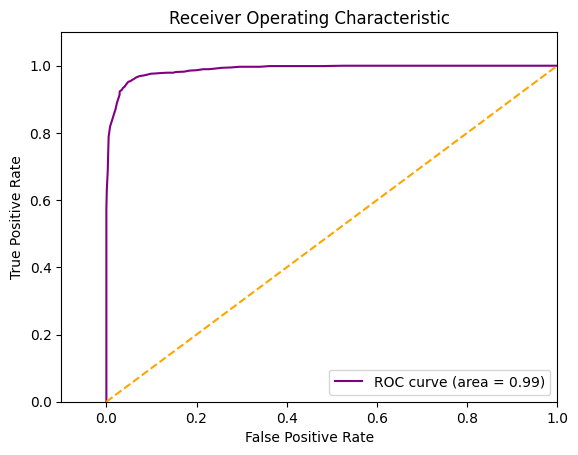

In [ ]:
perform_grid_search(RF, rf_param_grid, X_train_scaled_1, y_train_new, X_test_scaled_1, y_test_new)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'bootstrap': True, 'bootstrap_features': True, 'max_features': 0.5, 'max_samples': 0.8, 'n_estimators': 100}
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.68      0.77       986
           1       0.74      0.91      0.82       963

    accuracy                           0.80      1949
   macro avg       0.81      0.80      0.80      1949
weighted avg       0.81      0.80      0.79      1949

Accuracy Score: 0.80
Precision Score: 0.74
Recall Score: 0.91
F1 Score: 0.82
Sensitivity: 0.91
Specificity: 0.68
AUC score: 0.88


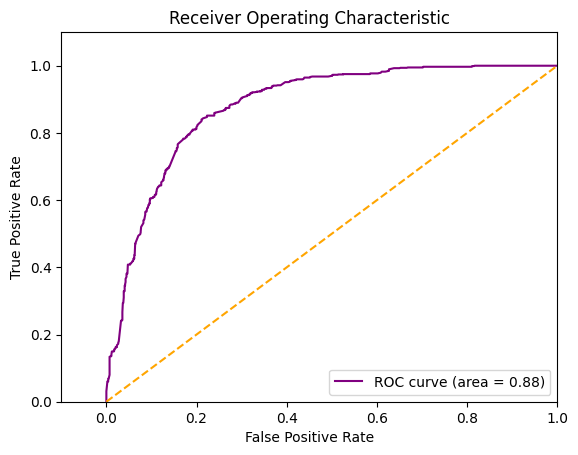

In [ ]:
perform_grid_search(BC, bagging_param_grid, X_train_scaled_1, y_train_new, X_test_scaled_1, y_test_new)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.5, 'n_estimators': 200}
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       986
           1       0.96      0.93      0.94       963

    accuracy                           0.95      1949
   macro avg       0.95      0.95      0.95      1949
weighted avg       0.95      0.95      0.95      1949

Accuracy Score: 0.95
Precision Score: 0.96
Recall Score: 0.93
F1 Score: 0.94
Sensitivity: 0.93
Specificity: 0.96
AUC score: 0.99


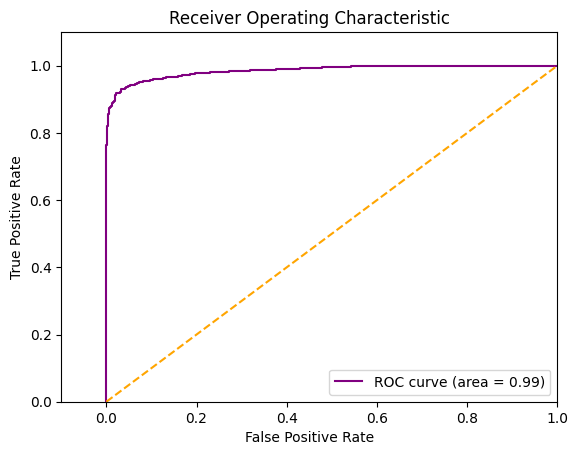

In [ ]:
perform_grid_search(ADA, ada_param_grid, X_train_scaled_1, y_train_new, X_test_scaled_1, y_test_new)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300}
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       986
           1       0.92      0.96      0.94       963

    accuracy                           0.94      1949
   macro avg       0.94      0.94      0.94      1949
weighted avg       0.94      0.94      0.94      1949

Accuracy Score: 0.94
Precision Score: 0.92
Recall Score: 0.96
F1 Score: 0.94
Sensitivity: 0.96
Specificity: 0.92
AUC score: 0.99


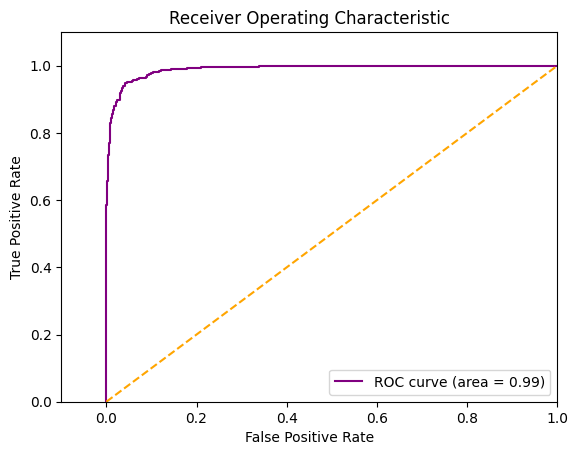

In [ ]:
perform_grid_search(XGB, xgb_param_grid, X_train_scaled_1, y_train_new, X_test_scaled_1, y_test_new)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters: {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'distance'}
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.82      0.89       986
           1       0.84      0.96      0.90       963

    accuracy                           0.89      1949
   macro avg       0.90      0.89      0.89      1949
weighted avg       0.90      0.89      0.89      1949

Accuracy Score: 0.89
Precision Score: 0.84
Recall Score: 0.96
F1 Score: 0.90
Sensitivity: 0.96
Specificity: 0.82
AUC score: 0.94


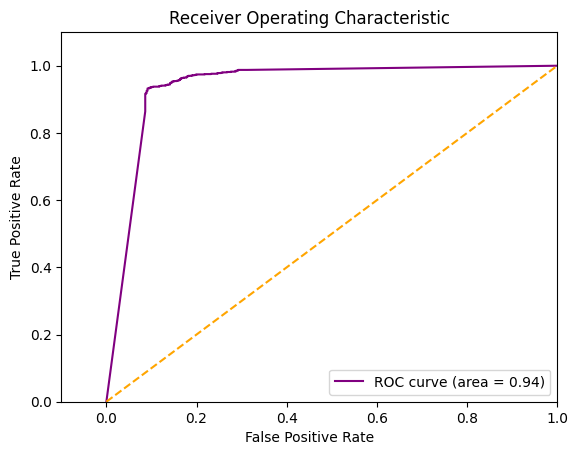

In [ ]:
perform_grid_search(KNN, knn_param_grid, X_train_scaled_1, y_train_new, X_test_scaled_1, y_test_new)

---

## Feature Selection

In [ ]:
# Correlation Based Feature Selection
corr = df.corr()
corr.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
gender,1.000000,-0.028202,0.020994,0.085447,-0.031005,0.056422,-0.006738,0.055180,-0.026109,-0.062581,0.008929
age,-0.028202,1.000000,0.276398,0.263796,0.679125,-0.361642,0.014180,0.238171,0.325942,0.265199,0.245257
hypertension,0.020994,0.276398,1.000000,0.108306,0.164243,-0.051761,-0.007913,0.174474,0.160189,0.111038,0.127904
heart_disease,0.085447,0.263796,0.108306,1.000000,0.114644,-0.028023,0.003092,0.161857,0.038899,0.048460,0.134914
ever_married,-0.031005,0.679125,0.164243,0.114644,1.000000,-0.352722,0.006261,0.155068,0.335705,0.259647,0.108340


<Axes: >

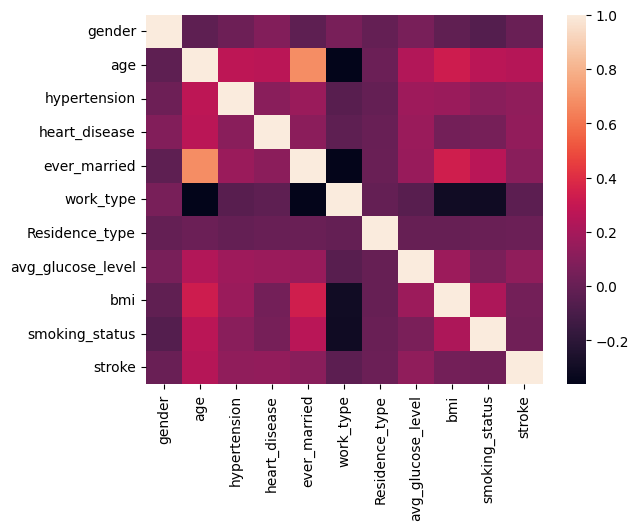

In [ ]:
sns.heatmap(corr)

In [ ]:
col = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.5:
            if col[j]:
                col[j] = False
relevant_col = df.columns[col]
# df.shape
relevant_col.shape
relevant_col

Index(['gender', 'age', 'hypertension', 'heart_disease', 'work_type',
       'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status',
       'stroke'],
      dtype='object')

In [ ]:
df1 = df.copy()
df1 = df[relevant_col]
df1

,gender,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,2,1,228.69,36.600000,1,1
1,0,61.0,0,0,3,0,202.21,28.893237,2,1
2,1,80.0,0,1,2,0,105.92,32.500000,2,1
3,0,49.0,0,0,2,1,171.23,34.400000,3,1
4,0,79.0,1,0,3,0,174.12,24.000000,2,1
...,...,...,...,...,...,...,...,...,...,...
5105,0,80.0,1,0,2,1,83.75,28.893237,2,0
5106,0,81.0,0,0,3,1,125.20,40.000000,2,0
5107,0,35.0,0,0,3,0,82.99,30.600000,2,0
5108,1,51.0,0,0,2,0,166.29,25.600000,1,0


<ipython-input-68-7d8d98feb3fb>:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df, x='stroke', y='bmi', palette='viridis', s=60, alpha=0.5)


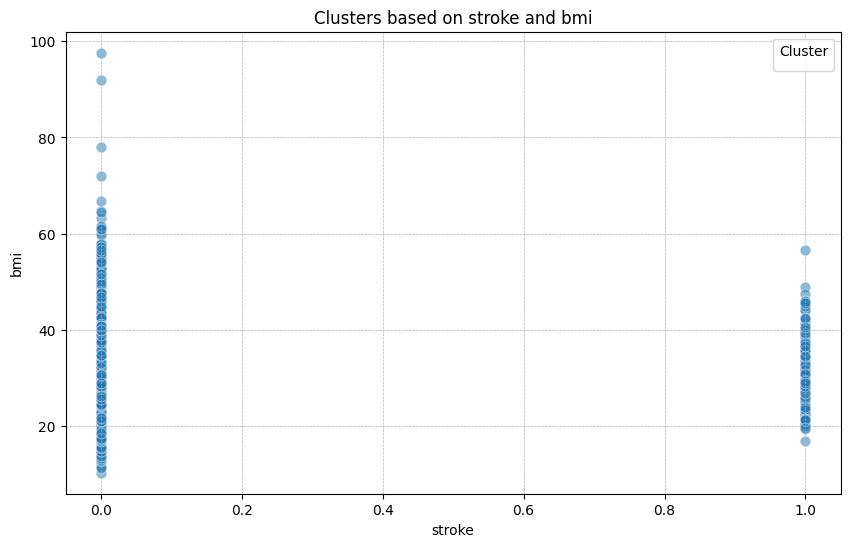

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='stroke', y='bmi', palette='viridis', s=60, alpha=0.5)
plt.title('Clusters based on stroke and bmi')
plt.legend(title='Cluster')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()